In [14]:
import numpy as np
#from scipy.optimize import minimize_scalar
from scipy.optimize import root
#from pandas import Series, DataFrame
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Qt5Agg')
%matplotlib qt5
#
# if pade.py is not in the current directory, set this path:
#
#sys.path.append('/home/thomas/Python')
import pade

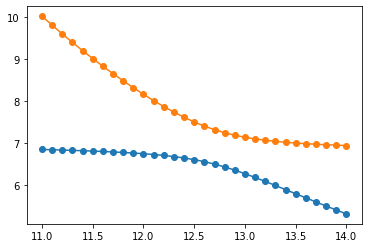

In [7]:
Angs2Bohr=1.8897259886
au2eV=27.211386027
au2cm=219474.63068
#
#  files in the current directory do not need the path name
#
#df = pd.read_csv("/home/thomas/Python/StabPlots/Stab_data/1D_a0.2_b0_c0.14/crossing_1.dat", delim_whitespace=True)
df = pd.read_csv("Stab_data/1D_a0.2_b0_c0.14/crossing_1.dat", delim_whitespace=True)
#df = pd.read_csv("crossing_1.dat", delim_whitespace=True)
plt.plot(df.L.values, df.E1.values, 'o-')
plt.plot(df.L.values, df.E2.values, 'o-')
plt.show()

In [8]:
df[:5]

,L,E1,E2
0,11.0,6.848704,10.026351
1,11.1,6.841982,9.812009
2,11.2,6.834901,9.603911
3,11.3,6.827366,9.402006
4,11.4,6.819261,9.206259


In [5]:
#
#   approximation as 2-by-2 Hamiltonian
#   H11(L) = const = resonance
#   H22(L) = a*L + b  (or anything else slowly varying)
#   H12 = H21 = W = constant
#
#   then find the closest approach of the energies
#   at that point H11 = H22 and E = H11 (or H22) +/- W
#   as well as 
#   Er = H11 = average(E1,E2) and pi*Gamma/2 = W = (E2-E1)/2
#
i_min = np.argmin(abs(df.E1.values-df.E2.values))
L_min=df.L[i_min]
E_1 = df.E1[i_min]
E_2 = df.E2[i_min]
print("L_min = %f" % (df.L[i_min]))
Er=0.5*(E_1 + E_2)
G=0.5 * np.pi * (E_2 - E_1)
print("First approximation: Er=%f   Gamma=%f" % (Er,G))
E_guess=(Er-0.5j*G)
print("Eres = {0}".format(E_guess))

L_min = 12.800000
First approximation: Er=6.840239   Gamma=1.281730
Eres = (6.8402391347150004-0.6408652159980824j)


In [9]:
#
#  seems as if going into the the complex plane from L_min 
#  so as to minimize dE_plus/dL is a good 1D option
#  then do newton from there
#
#  for this purpose we need a function that 
#  returns the derivative only 
#
def just_dE(L):
    E, dE = pade.E_plus(L[0]+1j*L[1], A, B, C, der=1)
    return [dE.real, dE.imag]

            6             5            4             3           2
-2.263e-06 x + 7.771e-05 x - 0.000751 x - 0.0009684 x + 0.06746 x - 0.4536 x + 1
           6             5            4           3          2
1.544e-05 x - 0.0005331 x + 0.006868 x - 0.04794 x + 0.1244 x + 0.003688 x - 0.01059
           6             5           4           3           2
1.004e-05 x - 0.0007202 x + 0.01166 x - 0.03616 x + 0.02337 x + 0.003744 x - 0.0007033


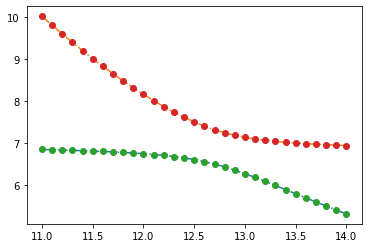

In [13]:
#
# make one long list of all energies
# (which requires the Ls twice)
# and fit it to a generalized Pade approximant of order n-n-n
#
LL = list(df.L.values) + list(df.L.values)
Es = list(df.E1.values) + list(df.E2.values)
n=6
A, B, C = pade.genpade2_via_lstsq(n, n, n, LL, Es, rcond=1e-14)
print(A)
print(B)
print(C)

#
# compare the input energies and the fitted curves
#
npts=100
Lplots=np.linspace(LL[0],LL[-1],npts)
E1plot=np.zeros(npts)
E2plot=np.zeros(npts)
for i in range(npts):
    E1plot[i]=pade.E_lower(Lplots[i], A, B, C)
    E2plot[i]=pade.E_upper(Lplots[i], A, B, C)
plt.cla()
plt.plot(Lplots,E1plot,'-.')
plt.plot(Lplots,E2plot,'-.')
plt.plot(df.L.values,df.E1.values,'o')
plt.plot(df.L.values,df.E2.values,'o')

In [15]:
#
#  evaluate the Pade approximant in the complex plane
#  plot the abs(derivative) on a log-scale
#
npts=81
rp=1
ip=8
Lrs = np.linspace(df.L.values[0]-rp, df.L.values[-1]+rp, npts)
Lis = np.linspace(0, +ip, npts)
absdEs = np.zeros([npts,npts])
for r in range(npts):
    for i in range(npts):
        L=[Lrs[r],Lis[i]]
        [dEr, dEi] = just_dE(L)
        absdEs[i,r] = np.log10(abs(dEr+1j*dEi))

plt.cla()        
plt.contourf(Lrs, Lis, absdEs, 10, cmap=plt.cm.jet_r)
plt.colorbar()
plt.show()

In [17]:
"""
  collects some results for small n
  look again very carefully at:
  - the derivative
  - the right root (should work for the other root, 
    but Im(L) negative, right?
  - the scipt.root function
  - why does this stray outside the original L-range?
    fit to larger L-ranges?
"""
L0_333=np.array([12.2, 2.93])
L0_444=np.array([11.8, 3.53])
L0_555=np.array([13.1, 3.04])
L0_777=np.array([14.9, 3.04])
sol = root(just_dE, L0_777)
sol.x

array([14.80189532,  2.99137826])

In [ ]:
Lstar=sol.x[0]+1j*sol.x[1]
print("L=(%f, %f)" % (Lstar.real, Lstar.imag))
E, dE = pade.E_plus(Lstar, A, B, C, der=1)
print("E=(%f, %f)" % (E.real, E.imag))
print(abs(dE))

In [18]:
"""

automatic loop over n

I wonder whether this works. The results suck.

"""
npts=50
Lrs = np.linspace(df.L.values[0], df.L.values[-1], npts)
Lis = np.linspace(0.0, 8.0, npts)
absdEs = np.zeros([npts,npts])

for n in [4, 5, 6, 7, 8]:
    A, B, C = pade.genpade2_via_lstsq(n, n, n, LL, Es, rcond=1e-14)
    for r in range(npts):
        for i in range(npts):
            L = [Lrs[r],Lis[i]]
            [dEr, dEi] = just_dE(L)
            absdEs[i,r] = np.log10(abs(complex(dEr, dEi)))    
    (i, r) = np.unravel_index(absdEs.argmin(), absdEs.shape)
    L0 = [Lrs[r], Lis[i]]
    sol = root(just_dE, L0)
    L0 = sol.x
    Lstar=complex(L0[0],L0[1])
    E, dE = pade.E_plus(Lstar, A, B, C, der=1)
    print("%2d  E=(%f, %f)   L=(%f, %f) dE=%e"  % (n,E.real,E.imag,L0[0],L0[1], abs(dE)))

 4  E=(5.577484, -5.258559)   L=(11.758195, 3.527790) dE=1.824215e-14
 5  E=(4.994710, -3.354643)   L=(13.070174, 3.048151) dE=5.579869e-14
 6  E=(3.835033, -2.158891)   L=(14.801895, 2.991378) dE=5.708510e-13
 7  E=(4.659993, -2.215275)   L=(14.000000, 2.448980) dE=8.111599e-03
 8  E=(4.771663, -2.034718)   L=(14.005551, 2.227597) dE=1.089630e-02
